# **Hypothesis Testing**

Joseph Lardie

September 2023

# **Imports**

In [1]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Seaborn
import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt
import plotly


# Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder

# Scipy
from scipy import stats
from scipy.stats import norm, pearsonr
import statsmodels.api as sm


# Sklearn Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, set_config
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# Warnings
import warnings
warnings.filterwarnings("ignore")
set_config(display = 'diagram')

## **Loading in datasets**

In [2]:
# Loading NYC Restaraunt Data
rdf = pd.read_csv('rdf')

In [3]:
# Loading NYC Restaraunt Data
ydf = pd.read_csv('ydf')

In [4]:
# Restaurant Inspection data
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208616 entries, 0 to 208615
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  208616 non-null  int64  
 1   DBA                    208042 non-null  object 
 2   BORO                   208616 non-null  object 
 3   BUILDING               208270 non-null  object 
 4   STREET                 208609 non-null  object 
 5   ZIPCODE                205933 non-null  float64
 6   CUISINE DESCRIPTION    206203 non-null  object 
 7   INSPECTION DATE        208616 non-null  object 
 8   ACTION                 206203 non-null  object 
 9   VIOLATION CODE         205056 non-null  object 
 10  VIOLATION DESCRIPTION  205056 non-null  object 
 11  CRITICAL FLAG          208616 non-null  object 
 12  SCORE                  198750 non-null  float64
 13  GRADE                  102151 non-null  object 
 14  GRADE DATE             93552 non-nul

In [5]:
# Yelp Reviews data
ydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   alias         847 non-null    object 
 1   name          847 non-null    object 
 2   image_url     847 non-null    object 
 3   url           847 non-null    object 
 4   review_count  847 non-null    int64  
 5   categories    847 non-null    object 
 6   rating        847 non-null    float64
 7   coordinates   847 non-null    object 
 8   transactions  847 non-null    object 
 9   location      847 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 66.3+ KB


# **Data Cleaning**

In [6]:
# Selecting subset of only restaurants from Brooklyn
brooklyndf = rdf[rdf['BORO'].str.lower() == 'brooklyn']

In [7]:
# Selecting subset of only restaurants in Brooklyn that have pizza in the cuisine description
pizza_brooklyn_subset = brooklyndf[(brooklyndf['CUISINE DESCRIPTION'].str.lower() == 'pizza')]

In [8]:
# Filtering out rows with NaN in the 'GRADE' column
pizza_brooklyn_subset = pizza_brooklyn_subset.dropna(subset=['GRADE'])

In [9]:
# Taking a look at Brooklyn pizza restaurants in inspection data
print(pizza_brooklyn_subset)

           CAMIS                       DBA      BORO BUILDING  \
241     50127840          PAPA JOHNS PIZZA  Brooklyn      189   
289     41688186                  TABLE 87  Brooklyn      620   
410     50089510              ROSA'S PIZZA  Brooklyn      374   
513     50131083                PARASHADES  Brooklyn      241   
770     50018601  BELLA PIZZA & RESTAURANT  Brooklyn      208   
...          ...                       ...       ...      ...   
207617  50099949          NICKY'S PIZZERIA  Brooklyn     1750   
207824  50097889                  DOMINO'S  Brooklyn     1972   
207828  40892913              JOJO'S PIZZA  Brooklyn     9502   
208342  50037525    BRADO THIN CRUST PIZZA  Brooklyn      155   
208412  41534086    LA PIZZA & CONVENIENCE  Brooklyn      887   

                     STREET  ZIPCODE CUISINE DESCRIPTION INSPECTION DATE  \
241                AVENUE U  11223.0               Pizza      09/29/2022   
289         ATLANTIC AVENUE  11217.0               Pizza      01/25

In [10]:
# Making the names of the restaurants in both data sets compatable for the merge
column_name = 'name'
ydf['name'] = ydf['name'].apply(lambda x: str(x).upper())

In [11]:
# Mergeing the two data sets on the names of the restaurants 
merged_df = pd.merge(pizza_brooklyn_subset, ydf, left_on='DBA', right_on='name', how='inner', indicator=True)

# Displaying the merged dataframe
print("\nMerged DataFrame:")
print(merged_df)


Merged DataFrame:
        CAMIS               DBA      BORO BUILDING             STREET  \
0    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
1    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
2    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
3    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
4    50127840  PAPA JOHNS PIZZA  Brooklyn      189           AVENUE U   
..        ...               ...       ...      ...                ...   
503  50056980           FAZIO'S  Brooklyn      709  KNICKERBOCKER AVE   
504  50079182      PIZZA SECRET  Brooklyn       72           5 AVENUE   
505  50079182      PIZZA SECRET  Brooklyn       72           5 AVENUE   
506  50127169      NORM'S PIZZA  Brooklyn      388           7 AVENUE   
507  50000967           WHEATED  Brooklyn      905      CHURCH AVENUE   

     ZIPCODE CUISINE DESCRIPTION INSPECTION DATE  \
0    11223.0               Pizza      09/29/2022   


In [12]:
merged_df['SCORE'].value_counts()

12.0    90
13.0    80
27.0    41
64.0    40
10.0    38
9.0     31
18.0    30
7.0     20
0.0     17
11.0    17
6.0     14
2.0     14
3.0     12
5.0     10
24.0     8
16.0     8
8.0      7
4.0      7
21.0     6
37.0     5
23.0     4
20.0     3
19.0     3
22.0     3
Name: SCORE, dtype: int64

In [13]:
merged_df['GRADE'].value_counts()

A    331
B    102
Z     52
C     11
P      8
N      4
Name: GRADE, dtype: int64

# **Hypothesis Testing**

## **Hypothesis Test 1:Try to find a correlation between scores on inspections and the ratings on YELP**

- The null hypothesis for this question would be that the restaurant inspection score/grade does not significantly affect the rating/reviews on Yelp for pizza restaurants in Brooklyn NY

- The alternative hypothesis for this question would be that the restaurant inspection score/grade does significantly affect the rating/ reviews on Yelp for the pizza restaurants in Brooklyn NY.

In [14]:
# Perform Pearson correlation test
correlation, p_value = pearsonr(merged_df['SCORE'], merged_df['rating'])

# Print results
print(f'Correlation: {correlation:.2f}')
print(f'P-value: {p_value:.4f}')

# Check for significance based on the p-value
if p_value < 0.05:
    print('The correlation is statistically significant.')
else:
    print('There is no significant correlation.')

Correlation: 0.15
P-value: 0.0007
The correlation is statistically significant.


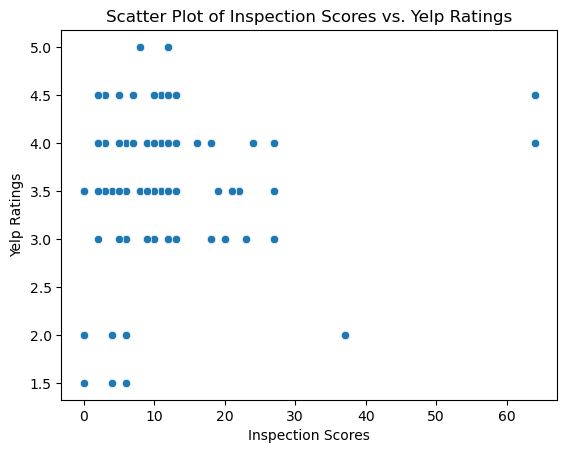

In [15]:
# Visualizing the correlation between 
sns.scatterplot(x=merged_df['SCORE'], y=merged_df['rating'])
plt.title('Scatter Plot of Inspection Scores vs. Yelp Ratings')
plt.xlabel('Inspection Scores')
plt.ylabel('Yelp Ratings')
plt.show()

## **Hypothesis Test 2:Try to find correlation between the inspection grades and the ratings on Yelp data**

In [16]:
# Remove rows with 'N', 'Z', and 'P' in the 'GRADE' column
# These letters signify: N = Not Yet Graded, Z = Grade Pending,
# P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure
merged_df = merged_df[~merged_df['GRADE'].isin(['N', 'Z', 'P'])]

In [17]:
# save list of columns needed for each group
#needed_col = ['GRADE', 'rating']

#merged_df[needed_col]

In [18]:
merged_df['rating'].value_counts()

3.5    177
4.0    171
3.0     40
4.5     37
2.0     11
5.0      5
1.5      3
Name: rating, dtype: int64

In [19]:
merged_df['GRADE'].value_counts()

A    331
B    102
C     11
Name: GRADE, dtype: int64

In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 3 to 507
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CAMIS                  444 non-null    int64   
 1   DBA                    444 non-null    object  
 2   BORO                   444 non-null    object  
 3   BUILDING               444 non-null    object  
 4   STREET                 444 non-null    object  
 5   ZIPCODE                440 non-null    float64 
 6   CUISINE DESCRIPTION    444 non-null    object  
 7   INSPECTION DATE        444 non-null    object  
 8   ACTION                 444 non-null    object  
 9   VIOLATION CODE         444 non-null    object  
 10  VIOLATION DESCRIPTION  444 non-null    object  
 11  CRITICAL FLAG          444 non-null    object  
 12  SCORE                  444 non-null    float64 
 13  GRADE                  444 non-null    object  
 14  GRADE DATE             444 non-null    obj

In [21]:
print("Number of non-null values in 'GRADE':", merged_df['GRADE'].count())
print("Number of non-null values in 'rating':", merged_df['rating'].count())

Number of non-null values in 'GRADE': 444
Number of non-null values in 'rating': 444


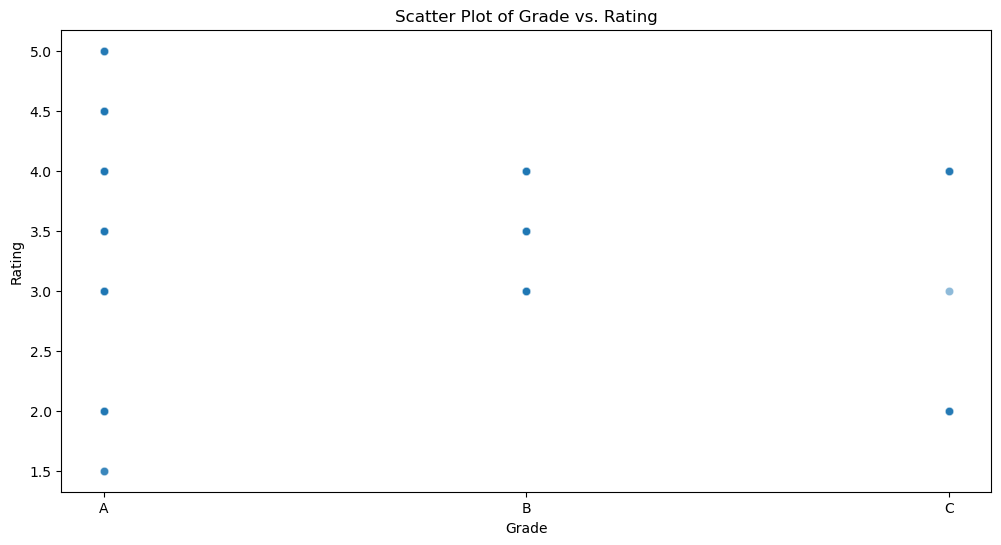

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='GRADE', y='rating', data=merged_df, alpha=0.5)
plt.title('Scatter Plot of Grade vs. Rating')
plt.xlabel('Grade')
plt.ylabel('Rating')
plt.show()

In [30]:
# review_count_counts = merged_df['review_count'].value_counts().sort_values(ascending=False)
print(merged_df['review_count'])

3       66
4       66
5      113
6       66
7       66
      ... 
503    215
504    272
505    272
506    114
507    398
Name: review_count, Length: 444, dtype: int64


In [32]:
review_count = merged_df['review_count']
rating = merged_df['rating']

# Calculate IQR
Q1 = review_count.quantile(0.25)
Q3 = review_count.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (review_count < Q1 - 1.5 * IQR) | (review_count > Q3 + 1.5 * IQR)

# Print outliers
print("Outliers:")
print(merged_df[outliers])

Outliers:
        CAMIS                        DBA      BORO BUILDING  \
325  50106466                  ROBERTA'S  Brooklyn        6   
327  50106466                  ROBERTA'S  Brooklyn        6   
329  41307383                  ROBERTA'S  Brooklyn       43   
331  41307383                  ROBERTA'S  Brooklyn       43   
333  41307383                  ROBERTA'S  Brooklyn       43   
335  50106466                  ROBERTA'S  Brooklyn        6   
337  41307383                  ROBERTA'S  Brooklyn       43   
342  50084972                JOE'S PIZZA  Brooklyn      483   
343  50084972                JOE'S PIZZA  Brooklyn      483   
344  50084972                JOE'S PIZZA  Brooklyn      483   
348  41349101                JOE'S PIZZA  Brooklyn      259   
349  41349101                JOE'S PIZZA  Brooklyn      259   
350  41349101                JOE'S PIZZA  Brooklyn      259   
354  50084972                JOE'S PIZZA  Brooklyn      483   
355  50084972                JOE'S PIZZA  Bro

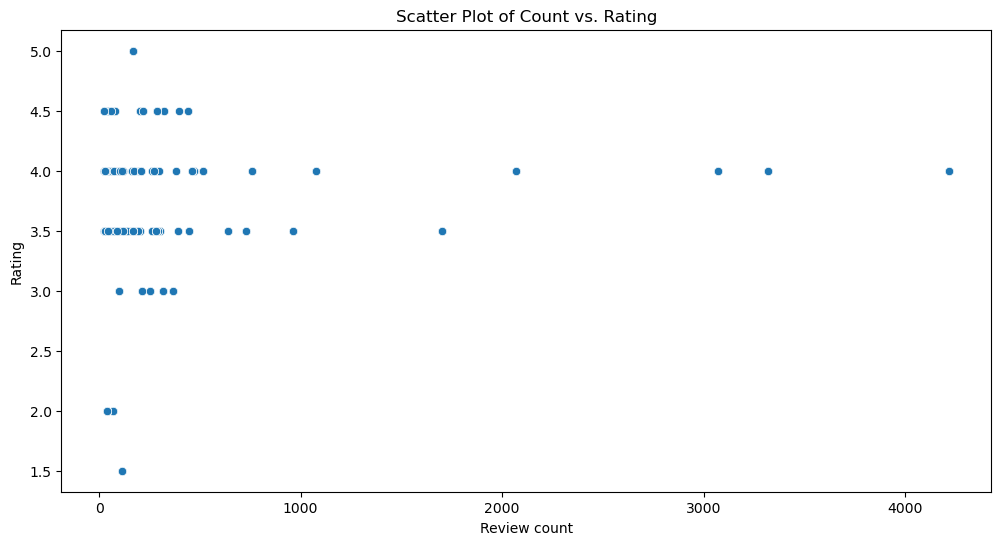

In [31]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='review_count', y='rating', data=merged_df)
plt.title('Scatter Plot of Count vs. Rating')
plt.xlabel('Review count')
plt.ylabel('Rating')
plt.show()

In [23]:
# Drop rows with NaN values if needed
original_length = len(merged_df)
merged_df = merged_df.dropna(subset=['GRADE', 'rating'])
new_length = len(merged_df)

print(f'Original length: {original_length}')
print(f'New length after dropping NaN values: {new_length}')

# Convert 'GRADE' column to numeric
merged_df['GRADE'] = pd.to_numeric(merged_df['GRADE'], errors='coerce')

# Convert 'rating' column to numeric
merged_df['rating'] = pd.to_numeric(merged_df['rating'], errors='coerce')

# Drop rows with infinite and NaN values in the 'rating' column
merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['rating'])

# Perform Pearson correlation test
if len(merged_df['GRADE']) < 2 or len(merged_df['rating']) < 2:
    print("Not enough data points to perform the correlation test.")
else:
    # Perform Pearson correlation test
    correlation, p_value = pearsonr(merged_df['GRADE'], merged_df['rating'])

    # Print results
    print(f'Correlation: {correlation:.2f}')
    print(f'P-value: {p_value:.4f}')

    # Check for significance based on the p-value
    if p_value < 0.05:
        print('The correlation is statistically significant.')
    else:
        print('There is no significant correlation.')


Original length: 444
New length after dropping NaN values: 444


ValueError: array must not contain infs or NaNs

## **Feature Engineering**

- Find out if there is a significant correlation between certain violations for certain restaurant types of specific areas/boros.

- Most common violations for each restaurant type and each set of chains if applicable for each boro.

- Do corporate restaurants or privately owned places get better scores/grades? What are the most common violations that cost the most points on the inspections.

- Construct predictive models to predict when initial and re-inspections are going to happen

- Construct predictive models to predict which restaurants will pass/fail inspections.

- Find out if there is correlation between a higher score/grade causing a restaurant to recive an overall better score on yelp. Look at the comparison between the results for coporate and privately owned places.